# Evaluating Model Performance and Plotting Results


## Step 1: Setting Up the Environment


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Step 2: Preparing Model, Data, and Training Components


Using device: cpu


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 229kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.31MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.9MB/s]



--- Displaying a few FashionMNIST samples ---


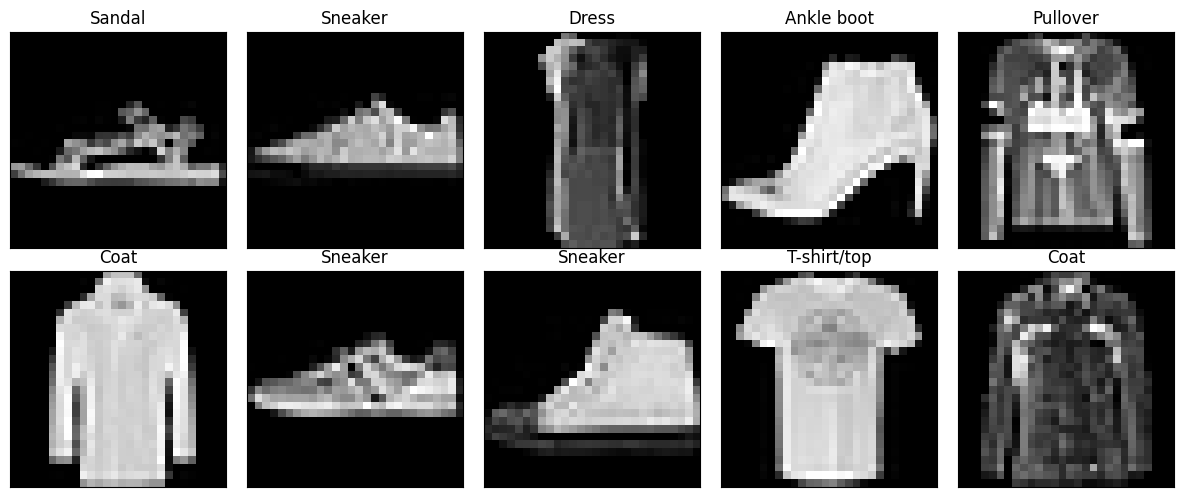

--- Sample display complete ---


In [ ]:
# Define a simple CNN model (remains the same as it's generic for 28x28 grayscale images)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * 7 * 7, num_classes) # Images are 28x28, after 2 pools -> 7x7

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7) # Flatten the tensor
        x = self.fc(x)
        return x

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs_to_run = 5 # Using 5 epochs for quicker demonstration

# Data Transformations for FashionMNIST
# We'll also define the inverse transform for visualization
mean = 0.2860
std = 0.3530
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)) # FashionMNIST mean and std
])

# Load FashionMNIST dataset
full_train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Define class names for FashionMNIST
fashion_mnist_classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Split training dataset into training and validation
train_size = int(0.8 * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size
train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, valid_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print("\n--- Displaying a few FashionMNIST samples ---")
# Get one batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter) # Use next(dataiter) for Python 3.x

# Reverse the normalization for visualization
# image = (image * std) + mean
# We'll plot 10 images
fig = plt.figure(figsize=(12, 5)) # Adjust figure size as needed
for idx in np.arange(10): # Plot first 10 images from the batch
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[]) # 2 rows, 5 columns

    # Detach from GPU if necessary and convert to numpy for plotting
    img = images[idx].cpu().numpy().squeeze() # Remove channel dimension for grayscale (1, 28, 28) -> (28, 28)

    # Reverse normalization: img = img * std + mean
    img = (img * std) + mean

    plt.imshow(img, cmap='gray')
    ax.set_title(fashion_mnist_classes[labels[idx]])
plt.tight_layout()
plt.show()
print("--- Sample display complete ---")

## Step 3: Training and Evaluating the Model


In [ ]:
# Instantiate model, criterion, and optimizer
model = SimpleCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train_and_evaluate(model, criterion, optimizer, train_loader, valid_loader, device, epochs=10):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    print(f"\nStarting training for {epochs} epochs on FashionMNIST...")
    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        current_train_loss, train_correct = 0.0, 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            current_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == targets).sum().item()

        avg_train_loss = current_train_loss / len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        current_valid_loss, valid_correct = 0.0, 0

        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                current_valid_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                valid_correct += (predicted == targets).sum().item()

        avg_valid_loss = current_valid_loss / len(valid_loader.dataset)
        valid_accuracy = valid_correct / len(valid_loader.dataset)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f'Epoch {epoch}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy*100:.2f}%')
        print(f'  Valid Loss: {avg_valid_loss:.4f} | Valid Accuracy: {valid_accuracy*100:.2f}%')

    return train_losses, valid_losses, train_accuracies, valid_accuracies

# Run training and evaluation
history = train_and_evaluate(model, criterion, optimizer, train_loader, valid_loader, device, epochs=num_epochs_to_run)
train_losses, valid_losses, train_accs, valid_accs = history


Starting training for 5 epochs on FashionMNIST...
Epoch 1/5:
  Train Loss: 0.4897 | Train Accuracy: 82.71%
  Valid Loss: 0.3780 | Valid Accuracy: 85.81%
Epoch 2/5:
  Train Loss: 0.3263 | Train Accuracy: 88.26%
  Valid Loss: 0.3136 | Valid Accuracy: 88.48%
Epoch 3/5:
  Train Loss: 0.2868 | Train Accuracy: 89.71%
  Valid Loss: 0.2791 | Valid Accuracy: 89.92%
Epoch 4/5:
  Train Loss: 0.2599 | Train Accuracy: 90.64%
  Valid Loss: 0.2552 | Valid Accuracy: 91.09%
Epoch 5/5:
  Train Loss: 0.2421 | Train Accuracy: 91.25%
  Valid Loss: 0.2532 | Valid Accuracy: 90.96%


## Step 4: Plotting Performance Metrics


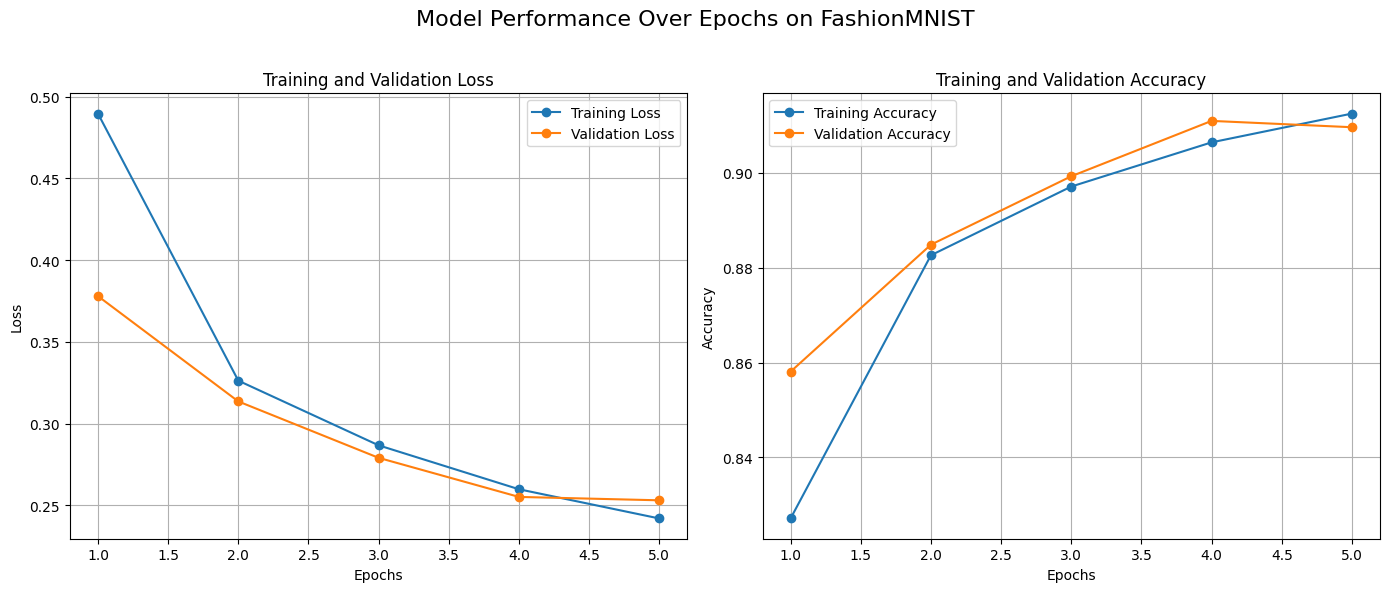

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
epochs_range = range(1, num_epochs_to_run + 1)
plt.plot(epochs_range, train_losses, 'o-', label='Training Loss')
plt.plot(epochs_range, valid_losses, 'o-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, 'o-', label='Training Accuracy')
plt.plot(epochs_range, valid_accs, 'o-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.suptitle('Model Performance Over Epochs on FashionMNIST', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()